In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform

import weakref 

from bayes_opt import BayesianOptimization
#from root_pandas import read_root


from data_cleaning import clean_df
from KFPF_lambda_cuts import KFPF_lambda_cuts
from plot_tools import AMS, preds_prob, plot_confusion_matrix, plt_sig_back
import tree_importer 
import uproot


#To save some memory we will delete unused variables
class TestClass(object): 
    def check(self): 
        print ("object is alive!") 
    def __del__(self): 
        print ("object deleted") 
        
from concurrent.futures import ThreadPoolExecutor
executor = ThreadPoolExecutor(7)

import gc
import ROOT
from ROOT import TFile, TTree

Welcome to JupyROOT 6.24/02


In [2]:

            
ROOT.gInterpreter.Declare('''
void Print_start(TCanvas* c) {
c->Print("hists.pdf(","pdf");
}
''')

ROOT.gInterpreter.Declare('''
void Print_continue(TCanvas* c) {
c->Print("hists.pdf","pdf");
}
''')

ROOT.gInterpreter.Declare('''
void Print_end(TCanvas* c) {
c->Print("hists.pdf)","pdf");
}
''')


ROOT.gInterpreter.Declare('''
TH2F* Divide2DHisto(const TH2F* h1, const TH2F* h2, const TString& name) {

  if(h1->GetNbinsX() != h2->GetNbinsX() || h1->GetNbinsY() != h2->GetNbinsY()) {
    throw std::runtime_error("Histograms should have the same number of bins!");
  }

  TH2F* res = dynamic_cast<TH2F*>(h1->Clone(name));
  res->Divide(h2);

  for(int i = 1; i <= h1->GetNbinsX(); ++i){
    for(int j = 1; j <= h1->GetNbinsY(); ++j) {
      const auto a = h1->GetBinContent(i, j);
      const auto b = h2->GetBinContent(i, j);
      const auto da = h1->GetBinError(i, j);
      const auto db = h2->GetBinError(i, j);
      if(a == 0 || b == 0) {
        continue;
      }
      double error = res->GetBinContent(i, j) * sqrt( ((da * da) / (a * a)) + ((db * db) / (b * b)) );
      res->SetBinError(i, j, error);
    }
  }
  return res;
}
''')

ROOT.gInterpreter.Declare('''
  auto legend_draw(TH1D* mc, TH1D* reco){
  auto legend = new TLegend(0.3,0.3,0.65,0.2);
  legend->AddEntry(mc,"Simulated","ep");
  legend->AddEntry(reco,"Efficiency corrected reconstructed","ep");
  legend -> SetLineWidth (0);
  legend->SetTextSize(0.04);
  legend->Draw();
  }
  ''')
    

True

In [3]:
a = ['index', 'chi2geo','chi2primneg', 'chi2primpos','distance', 'ldl','l','cosine_first', 'cosine_second', 'chi2_topo', 'cosine_topo',
 'mass', 'pT', 'b', 'eta', 'p', 'phi', 'rapidity', 'vtx_chi2_first', 'vtx_chi2_second', 'z_first', 'z_second', 'z_smaller', 'M', 'issignal', 'nhits_mvd_first',
 'nhits_mvd_second', 'nhits_mvd_sum', 'nhits_tot_first', 'nhits_tot_second', 'nhits_tot_sum']

#1st sample
df_dcm1 =  uproot.open('/home/shahid/Mount/gsi/u/Mount/lustre/khan/cbmsoft/at_tree_plainer/install/bin/dcm/c_0_pt_0_9_y_0_9_M_200_250.root:plain_tree',decompression_executor=executor,
                                  interpretation_executor=executor).arrays(library='pd',decompression_executor=executor,
                                  interpretation_executor=executor)
df_dcm1.columns = a
df_dcm1= df_dcm1[df_dcm1['issignal']>0]

#2nd sample
df_dcm2= uproot.open('/home/shahid/Mount/gsi/u/Mount/lustre/khan/cbmsoft/at_tree_plainer/install/bin/c_0_pt_0_9_y_0_9_M_200_250_dcm_126_250.root:plain_tree',decompression_executor=executor,
                                  interpretation_executor=executor).arrays(library='pd',decompression_executor=executor,
                                  interpretation_executor=executor)
df_dcm2.columns = a
df_dcm2= df_dcm2[df_dcm2['issignal']>0]

#fill histograms
import ROOT
from ROOT import TFile, TTree
bins =15
h2d_dcm1 = ROOT.TH2F("Mc DCM", "Reconstructed_{DCM1}/Simulated_{DCM1}", bins,0,3,bins,0,3)
for i in range(0,len( df_dcm1['rapidity'])):
    h2d_dcm1.Fill( df_dcm1['rapidity'].iloc[i],df_dcm1['pT'].iloc[i])

h2d_dcm2 = ROOT.TH2F("urqmd", "Reconstructed_{DCM2}/Simulated_{DCM2} ", bins,0,3,bins,0,3)
for i in range(0,len(df_dcm2['rapidity'])):
    h2d_dcm2.Fill(df_dcm2['rapidity'].iloc[i],df_dcm2['pT'].iloc[i])

In [4]:
file = TFile("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/dcm/m_200_250_dcm_all_15bins_125.root")
MC_DCM1=file.Get("SimParticles_McLambda/SimParticles_rapidity_SimParticles_pT_McLambda;1")
file1 = ROOT.TFile("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/dcm/m_200_250_dcm_all_126_250.root")
MC_URQMD=file1.Get("SimParticles_McLambda/SimParticles_rapidity_SimParticles_pT_McLambda;1")
#h2d_dcm1.Divide(MC_DCM1)
h2d_dcm1_err_updated = ROOT.Divide2DHisto(h2d_dcm1, MC_DCM1,"dcm_eff")
#h2d_dcm2.Divide(h2d_dcm1_err_updated)
#h2d_urqmd.Divide(MC_URQMD)
h2d_dcm2_err_updated = ROOT.Divide2DHisto(h2d_dcm2, h2d_dcm1_err_updated,"dcm_eff_corr")

In [10]:
c = ROOT.TCanvas("","")
for i in range(0,16):
    bin1 = bin2 =i
    ROOT.gStyle.SetPaintTextFormat("4.2f")
    corr_urqmd_y = h2d_dcm2_err_updated.ProjectionY("corr_urqmd_y",bin1,bin2)
    corr_urqmd_y . SetLineColor(ROOT.kRed)
    corr_urqmd_y . SetMarkerColor(ROOT.kRed)
    corr_urqmd_y . SetLineWidth(2)
    corr_urqmd_y . SetMarkerStyle(21)

    mc_urqmd_y = MC_URQMD.ProjectionY("mc_urqmd_y", bin1,bin2)
    mc_urqmd_y . SetTitle("Reconstructed_{URQMD} x (Reconstructed_{DCM}/Simulated_{DCM})")
    mc_urqmd_y . SetLineWidth(2)
    mc_urqmd_y . SetMarkerStyle(22)
    mc_urqmd_y . SetLineColor(ROOT.kBlue)
    mc_urqmd_y . SetMarkerColor(ROOT.kBlue)
    
    
    c.Clear()
    mc_urqmd_y . Draw("pe1")
    corr_urqmd_y . Draw("pe1same")
    ROOT.legend_draw( mc_urqmd_y, corr_urqmd_y)
    mc_urqmd_y.SetStats (0)
    ROOT.Print_continue(c)

    #h2d_urqmd.Draw("TEXT SAME")

ROOT.Print_end(c)

Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file hists.pdf
Info in <TCanvas::Print>: Current 

In [6]:
def draw_2d(hist,title,max_range):
    ROOT.gStyle.SetPaintTextFormat("4.2f")
    c = ROOT.TCanvas("","")
    c.Draw()
    hist.SetAxisRange(0, max_range, "Z");
    hist.SetTitle(title)
    hist.SetStats (0)
    hist.Draw("colz")
    hist.Draw("TEXT SAME")
    return c


Info in <TCanvas::Print>: png file hists.png has been created


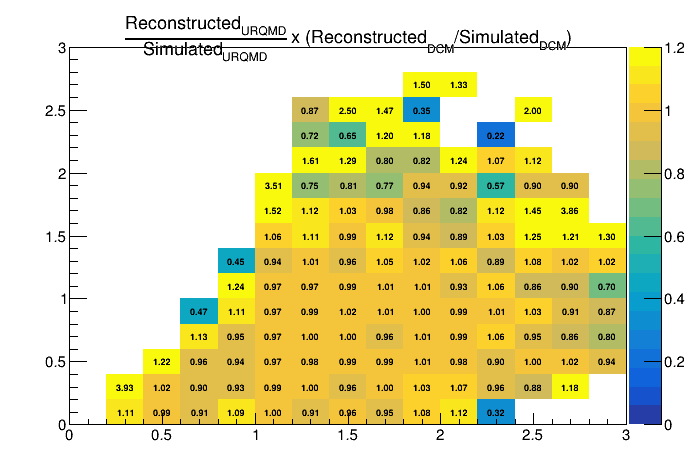

In [7]:
h2d_dcm2_err_updated.Divide(MC_URQMD)
c =draw_2d(h2d_dcm2_err_updated,"#frac{Reconstructed_{URQMD}}{Simulated_{URQMD}} x (Reconstructed_{DCM}/Simulated_{DCM})",1.2)
c.Print("hists.png")

Info in <TCanvas::Print>: png file hists_urqmd.png has been created


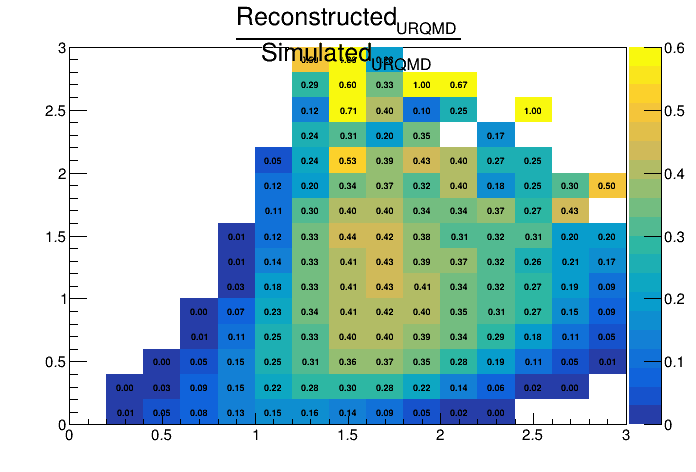

In [8]:
h2d_eff = ROOT.Divide2DHisto(h2d_dcm2, MC_URQMD,"")
c = draw_2d(h2d_eff,"#frac{Reconstructed_{URQMD}}{Simulated_{URQMD}}",0.6)
c.Print("hists_urqmd.png")

Info in <TCanvas::Print>: png file hists_dcm.png has been created


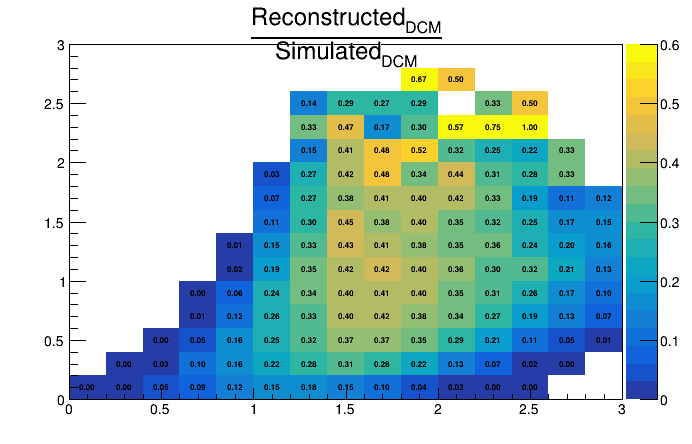

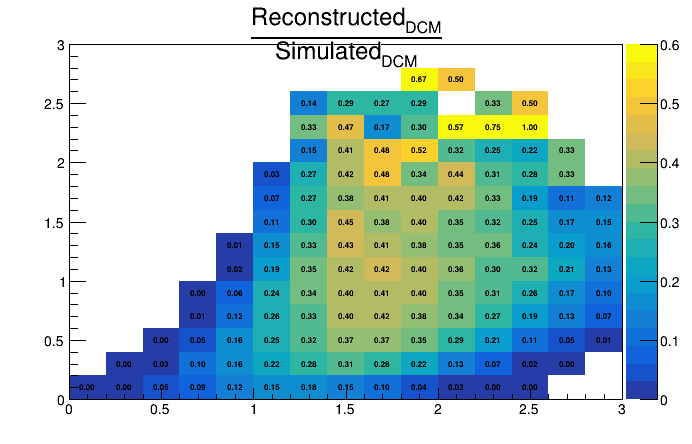

In [9]:
h2d_eff = ROOT.Divide2DHisto(h2d_dcm1, MC_DCM1,"")
c = draw_2d(h2d_eff,"#frac{Reconstructed_{DCM}}{Simulated_{DCM}}",0.6)
c.Print("hists_dcm.png")